In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDas", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDas", "transforms")
if (model_type=="DPT_Large" or model_type == "DPT_Hybrid"):
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

c:\Users\SOUGOTO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Using cache found in C:\Users\SOUGOTO/.cache\torch\hub\intel-isl_MiDas_master
c:\Users\SOUGOTO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository 

In [3]:
def generate_depth_map(img):
    batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(batch)
        prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    depth_map = (depth_map*255).astype(np.uint8) # 8 bit integer 0 to 255 --> pixel values
    depth_map = cv2.applyColorMap(depth_map, cv2.COLORMAP_MAGMA)
    return depth_map

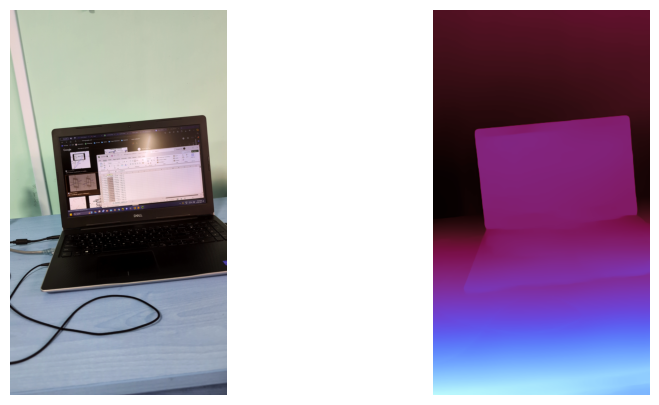

In [6]:
img = cv2.imread('my_data/992326147944002.jpg')
depth_map = generate_depth_map(img)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(depth_map)
plt.axis('off')
plt.show()

In [7]:
height, width, _ = img.shape
# fx = 2.9417e+03
# fy = 2.9396e+03
# cx = 2.0315e+03
# cy = 1.5063e+03
fx = 2.9545e+03
fy = 2.9621e+03
cx = 1.5024e+03
cy = 2.0827e+03
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

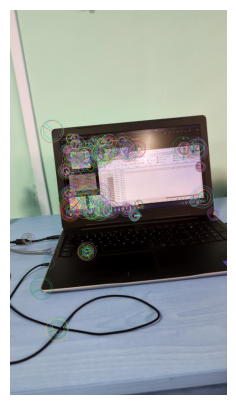

In [8]:
# Detecting Keypoints
orb = cv2.ORB_create()
Kp, des = orb.detectAndCompute(img, None)
# visualizing the keypoints
imgORB = cv2.drawKeypoints(img, Kp, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(5, 5))
plt.imshow(imgORB)
plt.axis('off')
plt.show()

In [9]:
Kp_np = np.array([k.pt for k in Kp])
Kp_np.shape

(500, 2)

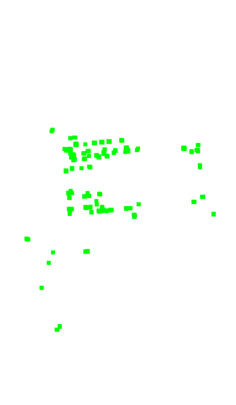

In [10]:
Kp_img = np.ones((height, width, 3), dtype=np.uint8)*255
dot_size=20
for pt in Kp_np:
    col, row = pt
    col, row = int(col), int(row)
    Kp_img[row - dot_size // 2:row + dot_size // 2, col - dot_size // 2:col + dot_size // 2, :] = [0, 255, 0]
plt.figure(figsize=(5, 5))
plt.imshow(Kp_img)
plt.axis('off')
plt.show()

In [9]:
Kp_depth = (depth_map[Kp_np[:, 1].astype(int), Kp_np[:, 0].astype(int), 0] + depth_map[Kp_np[:, 1].astype(int), Kp_np[:, 0].astype(int), 1] + depth_map[Kp_np[:, 1].astype(int), Kp_np[:, 0].astype(int), 2])/3
Kp_depth.shape

(500,)

In [10]:
np.max(Kp_depth), np.min(Kp_depth)

(85.0, 0.6666666666666666)

In [11]:
Kp_3D_ = []
for Kp in Kp_np:
    u, v = Kp
    depth = np.mean(depth_map[int(v), int(u), :])
    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth
    Kp_3D_.append((x, y, z))
Kp_pcd = o3d.geometry.PointCloud()
Kp_pcd.points = o3d.utility.Vector3dVector(Kp_3D_)
Kp_pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# visualization
o3d.visualization.draw_geometries([Kp_pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [12]:
Kp_ = []
for p3d in Kp_3D_:
    Kpt = K @ p3d
    Kpt = Kpt / Kpt[-1]
    Kpt = Kpt[:-1]
    Kp_.append(Kpt)

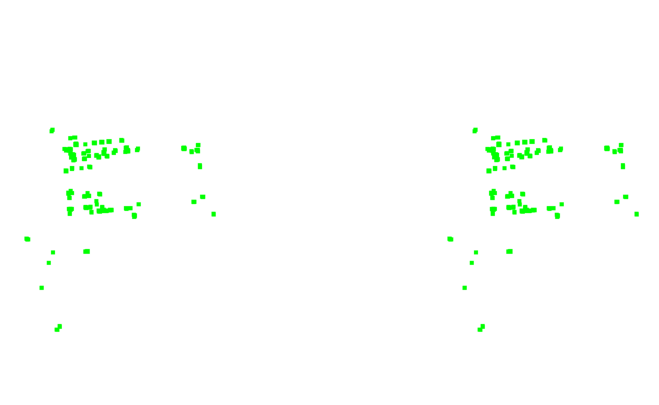

In [13]:
Kp_img_ = np.ones((height, width, 3), dtype=np.uint8)*255
dot_size=20
for pt in Kp_:
    col, row = pt
    col, row = int(col), int(row)
    Kp_img_[row - dot_size // 2:row + dot_size // 2, col - dot_size // 2:col + dot_size // 2, :] = [0, 255, 0]
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(Kp_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(Kp_img_)
plt.axis('off')
plt.show()